# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Multi agent DDPG algorithm from [Lowe et. al. MADDPG paper](https://arxiv.org/abs/1706.02275) <br>
Some ideas and inspiration taken from Amit Patel. ([Blog](https://medium.com/@amitpatel.gt/maddpg-91caa221d75e) and [GitHub repo](https://github.com/gtg162y/DRLND/tree/master/P3_Collab_Compete))

In [7]:
from datetime import datetime
import math

#temporary
#import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import copy
import random
import pickle
from models import *
import os

In [8]:
from models import *
#this contains actor_network and critic_network classes
#ddpg_Agent is a class for a single agent. It depends on num_agents as this dictates input size to critic

from agent import *
#contains ddpg_Agent and replay buffer classes. Also a noise generation function


In [9]:
HIDDEN1_SIZE = 256#512#300
HIDDEN2_SIZE = 128#256

#Ornstein-Uhlenbeck Noise
OU_THETA = 0.15
OU_SIGMA = 0.1 #0.2

GAUSSIAN_MEAN = 0
GAUSSIAN_STDEV = 0.5

#Decay amplitude of noise
NOISE_START = 1.0
NOISE_DECAY = 0.999
NOISE_END = 0.1
print('Takes %s decays for noise to reach %s'% (math.log((NOISE_END/NOISE_START),NOISE_DECAY), NOISE_END) )

REPLAY_MAX_SIZE = 1e5#1e6
BATCH_SIZE = 256

GAMMA=0.99
CRITIC_LR = 3e-4
ACTOR_LR = 1e-4
TAU = 1e-3


N_RANDOM = 300 #500
UPDATES_PER_STEP = 3

checkpoint_dir = "./checkpoints"
run_name = datetime.now().strftime('%Y%m%d_%H%M')
print('Run name = ',run_name)
SAVE_EVERY = 100

NUM_EPISODES = 2500

batch_norm = False#True

Takes 2301.4336084694537 decays for noise to reach 0.1
Run name =  20200610_2154


In [10]:
def timedelta_to_str(d):
    '''function to format a timedelta string nicely'''
    s = d.seconds
    h = math.floor(s/3600)
    m = math.floor((s-h*3600)/60)
    return('%sh %sm'%(h,m))

In [11]:
#train

maddpg = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents, 
                hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE, 
                max_replay_size=REPLAY_MAX_SIZE, batch_size=BATCH_SIZE,
                actor_lr=ACTOR_LR, critic_lr=CRITIC_LR, 
                gamma=GAMMA, tau=TAU, batch_norm=batch_norm)


score_history = []
action_history = [] #no noise
noise_history = []

start_time = datetime.now()

maddpg.learn_in_step = False #At start do not perform learn step (weights update), only add to replay memory
ep = NOISE_START
for episode in range(NUM_EPISODES):                                      
    env_info = env.reset(train_mode=False)[brain_name]       
    states = env_info.vector_observations                  
    #shape (2,24), (num_agents,state_size)
    scores = np.zeros(num_agents)   
    noise_generator = gaussian_noise(action_size = action_size, num_agents = num_agents, mean =GAUSSIAN_MEAN, stdev=GAUSSIAN_STDEV)

    if episode<N_RANDOM: 
        rand=True
        maddpg.learn_in_step = False
    else:
        rand=False
        maddpg.learn_in_step = True
        ep = max(ep*NOISE_DECAY,NOISE_END)
    while True:
        if rand:
            actions  = np.random.randn(num_agents, action_size)
            actions = np.clip(actions, -1, 1)
        else:
            actions = maddpg.get_actions(states) # use actors to select action for each agent.size (num_agents, action_size)
            action_history.append(actions)
            noise = ep * noise_generator.get_noise() #add noise
            noise_history.append(noise)
            actions = np.clip(actions+noise, -1, 1)
        
        env_info = env.step(actions)[brain_name]  
        
        next_states = env_info.vector_observations         
        rewards = env_info.rewards #list of length num_agents
        dones = env_info.local_done #list of length num_agents 
        
        maddpg.step(states,actions,rewards,next_states,dones,UPDATES_PER_STEP)
        
        scores += env_info.rewards 
        states = next_states
        if np.any(dones):                                  
            break
    #print('Score (max over agents) from episode {}: {}'.format(episode, np.max(scores)))
    
    score_history.append(np.max(scores))
    now_time = datetime.now()
    run_time = now_time-start_time
    forecast_time = (run_time / (episode + 1)) * (NUM_EPISODES - episode - 1)
    print('episode = %s, score = %.3f, ep = %s running for: %s, time to go: %s'%(episode+1,np.max(scores),ep,
                                                                    timedelta_to_str(run_time),
                                                                    timedelta_to_str(forecast_time)))

    
    if episode%SAVE_EVERY==0 and episode!=0:
        maddpg.checkpoint(run_name, checkpoint_dir, episode, scores = score_history)
        print('checkpoint saved ep',episode)
        print('step count = ',maddpg.learn_step_count)
#Score (max over agents) from episode 1: 0.0

episode = 1, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 0h 2m
episode = 2, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 12m
episode = 3, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 7m
episode = 4, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 5m
episode = 5, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 4m
episode = 6, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 3m
episode = 7, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 2m
episode = 8, score = 0.100, ep = 1.0 running for: 0h 0m, time to go: 1h 21m
episode = 9, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 18m
episode = 10, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 16m
episode = 11, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 15m
episode = 12, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 14m
episode = 13, score = 0.000, ep = 1.0 running for: 0h 0m, time to go: 1h 12m
episode = 14, 

episode = 108, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 8m
episode = 109, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 8m
episode = 110, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 8m
episode = 111, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 112, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 113, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 114, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 115, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 116, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 117, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 118, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 119, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 7m
episode = 120, score = 0.000, ep = 1.0 running for: 0h 3m, time to go: 1h 6m

episode = 214, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 215, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 216, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 217, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 218, score = 0.100, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 219, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 220, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 221, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 222, score = 0.100, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 223, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 224, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 225, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m
episode = 226, score = 0.000, ep = 1.0 running for: 0h 6m, time to go: 1h 5m

episode = 317, score = 0.000, ep = 0.9831353223738244 running for: 0h 15m, time to go: 1h 44m
episode = 318, score = 0.000, ep = 0.9821521870514506 running for: 0h 15m, time to go: 1h 44m
episode = 319, score = 0.000, ep = 0.9811700348643991 running for: 0h 15m, time to go: 1h 45m
episode = 320, score = 0.000, ep = 0.9801888648295347 running for: 0h 15m, time to go: 1h 45m
episode = 321, score = 0.000, ep = 0.9792086759647052 running for: 0h 15m, time to go: 1h 45m
episode = 322, score = 0.000, ep = 0.9782294672887405 running for: 0h 15m, time to go: 1h 45m
episode = 323, score = 0.100, ep = 0.9772512378214517 running for: 0h 15m, time to go: 1h 46m
episode = 324, score = 0.000, ep = 0.9762739865836303 running for: 0h 15m, time to go: 1h 46m
episode = 325, score = 0.000, ep = 0.9752977125970467 running for: 0h 15m, time to go: 1h 46m
episode = 326, score = 0.090, ep = 0.9743224148844496 running for: 0h 15m, time to go: 1h 46m
episode = 327, score = 0.000, ep = 0.9733480924695651 runnin

episode = 404, score = 0.000, ep = 0.9011784036598737 running for: 0h 20m, time to go: 1h 47m
episode = 405, score = 0.000, ep = 0.9002772252562138 running for: 0h 20m, time to go: 1h 47m
episode = 406, score = 0.000, ep = 0.8993769480309576 running for: 0h 20m, time to go: 1h 47m
episode = 407, score = 0.000, ep = 0.8984775710829266 running for: 0h 20m, time to go: 1h 47m
episode = 408, score = 0.000, ep = 0.8975790935118436 running for: 0h 20m, time to go: 1h 47m
episode = 409, score = 0.000, ep = 0.8966815144183318 running for: 0h 20m, time to go: 1h 47m
episode = 410, score = 0.000, ep = 0.8957848329039134 running for: 0h 21m, time to go: 1h 47m
episode = 411, score = 0.000, ep = 0.8948890480710096 running for: 0h 21m, time to go: 1h 47m
episode = 412, score = 0.000, ep = 0.8939941590229386 running for: 0h 21m, time to go: 1h 47m
episode = 413, score = 0.000, ep = 0.8931001648639156 running for: 0h 21m, time to go: 1h 47m
episode = 414, score = 0.000, ep = 0.8922070646990518 runnin

episode = 492, score = 0.000, ep = 0.8252275899809898 running for: 0h 25m, time to go: 1h 44m
episode = 493, score = 0.000, ep = 0.8244023623910088 running for: 0h 25m, time to go: 1h 44m
episode = 494, score = 0.000, ep = 0.8235779600286178 running for: 0h 25m, time to go: 1h 44m
episode = 495, score = 0.000, ep = 0.8227543820685892 running for: 0h 25m, time to go: 1h 44m
episode = 496, score = 0.000, ep = 0.8219316276865206 running for: 0h 25m, time to go: 1h 44m
episode = 497, score = 0.000, ep = 0.8211096960588341 running for: 0h 26m, time to go: 1h 44m
episode = 498, score = 0.000, ep = 0.8202885863627752 running for: 0h 26m, time to go: 1h 44m
episode = 499, score = 0.000, ep = 0.8194682977764125 running for: 0h 26m, time to go: 1h 44m
episode = 500, score = 0.000, ep = 0.818648829478636 running for: 0h 26m, time to go: 1h 44m
episode = 501, score = 0.000, ep = 0.8178301806491574 running for: 0h 26m, time to go: 1h 44m
checkpoint saved ep 500
step count =  9144
episode = 502, sco

episode = 579, score = 0.000, ep = 0.7564343028582378 running for: 0h 31m, time to go: 1h 43m
episode = 580, score = 0.000, ep = 0.7556778685553796 running for: 0h 31m, time to go: 1h 43m
episode = 581, score = 0.000, ep = 0.7549221906868242 running for: 0h 31m, time to go: 1h 43m
episode = 582, score = 0.000, ep = 0.7541672684961374 running for: 0h 31m, time to go: 1h 43m
episode = 583, score = 0.000, ep = 0.7534131012276413 running for: 0h 31m, time to go: 1h 43m
episode = 584, score = 0.000, ep = 0.7526596881264136 running for: 0h 31m, time to go: 1h 43m
episode = 585, score = 0.000, ep = 0.7519070284382872 running for: 0h 31m, time to go: 1h 43m
episode = 586, score = 0.000, ep = 0.7511551214098489 running for: 0h 31m, time to go: 1h 43m
episode = 587, score = 0.000, ep = 0.750403966288439 running for: 0h 31m, time to go: 1h 43m
episode = 588, score = 0.000, ep = 0.7496535623221505 running for: 0h 31m, time to go: 1h 44m
episode = 589, score = 0.000, ep = 0.7489039087598284 running

episode = 666, score = 0.000, ep = 0.6933758171534341 running for: 0h 42m, time to go: 1h 57m
episode = 667, score = 0.000, ep = 0.6926824413362807 running for: 0h 42m, time to go: 1h 57m
episode = 668, score = 0.000, ep = 0.6919897588949444 running for: 0h 42m, time to go: 1h 57m
episode = 669, score = 0.000, ep = 0.6912977691360495 running for: 0h 43m, time to go: 1h 57m
episode = 670, score = 0.100, ep = 0.6906064713669134 running for: 0h 43m, time to go: 1h 58m
episode = 671, score = 0.000, ep = 0.6899158648955466 running for: 0h 43m, time to go: 1h 58m
episode = 672, score = 0.000, ep = 0.689225949030651 running for: 0h 43m, time to go: 1h 58m
episode = 673, score = 0.000, ep = 0.6885367230816204 running for: 0h 43m, time to go: 1h 58m
episode = 674, score = 0.000, ep = 0.6878481863585387 running for: 0h 43m, time to go: 1h 58m
episode = 675, score = 0.000, ep = 0.6871603381721801 running for: 0h 43m, time to go: 1h 58m
episode = 676, score = 0.000, ep = 0.686473177834008 running 

episode = 754, score = 0.100, ep = 0.6349384896673435 running for: 0h 55m, time to go: 2h 8m
episode = 755, score = 0.000, ep = 0.6343035511776761 running for: 0h 55m, time to go: 2h 8m
episode = 756, score = 0.000, ep = 0.6336692476264985 running for: 0h 55m, time to go: 2h 8m
episode = 757, score = 0.000, ep = 0.6330355783788719 running for: 0h 55m, time to go: 2h 8m
episode = 758, score = 0.100, ep = 0.632402542800493 running for: 0h 55m, time to go: 2h 8m
episode = 759, score = 0.100, ep = 0.6317701402576925 running for: 0h 56m, time to go: 2h 8m
episode = 760, score = 0.000, ep = 0.6311383701174348 running for: 0h 56m, time to go: 2h 8m
episode = 761, score = 0.000, ep = 0.6305072317473174 running for: 0h 56m, time to go: 2h 8m
episode = 762, score = 0.000, ep = 0.6298767245155701 running for: 0h 56m, time to go: 2h 8m
episode = 763, score = 0.100, ep = 0.6292468477910546 running for: 0h 56m, time to go: 2h 9m
episode = 764, score = 0.000, ep = 0.6286176009432635 running for: 0h 5

episode = 842, score = 0.000, ep = 0.5814262275775862 running for: 1h 13m, time to go: 2h 24m
episode = 843, score = 0.200, ep = 0.5808448013500086 running for: 1h 13m, time to go: 2h 25m
episode = 844, score = 0.000, ep = 0.5802639565486586 running for: 1h 13m, time to go: 2h 24m
episode = 845, score = 0.000, ep = 0.57968369259211 running for: 1h 13m, time to go: 2h 24m
episode = 846, score = 0.000, ep = 0.5791040088995179 running for: 1h 14m, time to go: 2h 24m
episode = 847, score = 0.000, ep = 0.5785249048906184 running for: 1h 14m, time to go: 2h 24m
episode = 848, score = 0.100, ep = 0.5779463799857277 running for: 1h 14m, time to go: 2h 25m
episode = 849, score = 0.100, ep = 0.577368433605742 running for: 1h 14m, time to go: 2h 25m
episode = 850, score = 0.000, ep = 0.5767910651721362 running for: 1h 14m, time to go: 2h 25m
episode = 851, score = 0.100, ep = 0.576214274106964 running for: 1h 15m, time to go: 2h 26m
episode = 852, score = 0.000, ep = 0.5756380598328571 running fo

episode = 929, score = 0.100, ep = 0.5329569060230741 running for: 1h 23m, time to go: 2h 20m
episode = 930, score = 0.100, ep = 0.532423949117051 running for: 1h 23m, time to go: 2h 20m
episode = 931, score = 0.100, ep = 0.531891525167934 running for: 1h 23m, time to go: 2h 20m
episode = 932, score = 0.000, ep = 0.5313596336427661 running for: 1h 23m, time to go: 2h 20m
episode = 933, score = 0.000, ep = 0.5308282740091232 running for: 1h 23m, time to go: 2h 20m
episode = 934, score = 0.000, ep = 0.5302974457351142 running for: 1h 23m, time to go: 2h 20m
episode = 935, score = 0.000, ep = 0.5297671482893791 running for: 1h 23m, time to go: 2h 20m
episode = 936, score = 0.000, ep = 0.5292373811410898 running for: 1h 23m, time to go: 2h 19m
episode = 937, score = 0.100, ep = 0.5287081437599487 running for: 1h 23m, time to go: 2h 19m
episode = 938, score = 0.100, ep = 0.5281794356161887 running for: 1h 23m, time to go: 2h 19m
episode = 939, score = 0.000, ep = 0.5276512561805725 running 

episode = 1016, score = 0.100, ep = 0.4885281230967259 running for: 1h 31m, time to go: 2h 12m
episode = 1017, score = 0.000, ep = 0.48803959497362914 running for: 1h 31m, time to go: 2h 12m
episode = 1018, score = 0.100, ep = 0.4875515553786555 running for: 1h 31m, time to go: 2h 12m
episode = 1019, score = 0.000, ep = 0.48706400382327686 running for: 1h 31m, time to go: 2h 12m
episode = 1020, score = 0.100, ep = 0.4865769398194536 running for: 1h 31m, time to go: 2h 12m
episode = 1021, score = 0.100, ep = 0.48609036287963414 running for: 1h 31m, time to go: 2h 12m
episode = 1022, score = 0.000, ep = 0.48560427251675453 running for: 1h 31m, time to go: 2h 12m
episode = 1023, score = 0.000, ep = 0.48511866824423777 running for: 1h 31m, time to go: 2h 12m
episode = 1024, score = 0.100, ep = 0.4846335495759935 running for: 1h 31m, time to go: 2h 12m
episode = 1025, score = 0.000, ep = 0.4841489160264175 running for: 1h 31m, time to go: 2h 12m
episode = 1026, score = 0.100, ep = 0.4836647

episode = 1102, score = 0.000, ep = 0.4482512994620033 running for: 1h 44m, time to go: 2h 12m
episode = 1103, score = 0.000, ep = 0.4478030481625413 running for: 1h 44m, time to go: 2h 12m
episode = 1104, score = 0.100, ep = 0.44735524511437874 running for: 1h 45m, time to go: 2h 12m
episode = 1105, score = 0.100, ep = 0.4469078898692644 running for: 1h 45m, time to go: 2h 12m
episode = 1106, score = 0.000, ep = 0.4464609819793951 running for: 1h 45m, time to go: 2h 13m
episode = 1107, score = 0.100, ep = 0.44601452099741573 running for: 1h 45m, time to go: 2h 13m
episode = 1108, score = 0.100, ep = 0.4455685064764183 running for: 1h 46m, time to go: 2h 13m
episode = 1109, score = 0.000, ep = 0.4451229379699419 running for: 1h 46m, time to go: 2h 13m
episode = 1110, score = 0.100, ep = 0.44467781503197196 running for: 1h 46m, time to go: 2h 13m
episode = 1111, score = 0.000, ep = 0.44423313721693997 running for: 1h 46m, time to go: 2h 13m
episode = 1112, score = 0.100, ep = 0.44378890

episode = 1188, score = 0.100, ep = 0.41129510865353336 running for: 1h 59m, time to go: 2h 11m
episode = 1189, score = 0.000, ep = 0.41088381354487985 running for: 1h 59m, time to go: 2h 11m
episode = 1190, score = 0.000, ep = 0.410472929731335 running for: 1h 59m, time to go: 2h 11m
episode = 1191, score = 0.100, ep = 0.41006245680160364 running for: 1h 59m, time to go: 2h 11m
episode = 1192, score = 0.000, ep = 0.40965239434480205 running for: 1h 59m, time to go: 2h 11m
episode = 1193, score = 0.100, ep = 0.40924274195045723 running for: 2h 0m, time to go: 2h 11m
episode = 1194, score = 0.100, ep = 0.40883349920850676 running for: 2h 0m, time to go: 2h 11m
episode = 1195, score = 0.100, ep = 0.40842466570929825 running for: 2h 0m, time to go: 2h 11m
episode = 1196, score = 0.000, ep = 0.40801624104358897 running for: 2h 0m, time to go: 2h 11m
episode = 1197, score = 0.100, ep = 0.4076082248025454 running for: 2h 0m, time to go: 2h 11m
episode = 1198, score = 0.000, ep = 0.4072006165

episode = 1275, score = 0.100, ep = 0.37700839448485435 running for: 2h 15m, time to go: 2h 9m
episode = 1276, score = 0.100, ep = 0.3766313860903695 running for: 2h 15m, time to go: 2h 9m
episode = 1277, score = 0.100, ep = 0.37625475470427916 running for: 2h 15m, time to go: 2h 9m
episode = 1278, score = 0.100, ep = 0.3758784999495749 running for: 2h 15m, time to go: 2h 9m
episode = 1279, score = 0.090, ep = 0.3755026214496253 running for: 2h 16m, time to go: 2h 9m
episode = 1280, score = 0.090, ep = 0.3751271188281757 running for: 2h 16m, time to go: 2h 9m
episode = 1281, score = 0.000, ep = 0.3747519917093475 running for: 2h 16m, time to go: 2h 9m
episode = 1282, score = 0.090, ep = 0.37437723971763814 running for: 2h 16m, time to go: 2h 9m
episode = 1283, score = 0.000, ep = 0.37400286247792053 running for: 2h 16m, time to go: 2h 9m
episode = 1284, score = 0.000, ep = 0.3736288596154426 running for: 2h 16m, time to go: 2h 9m
episode = 1285, score = 0.100, ep = 0.37325523075582717 

episode = 1362, score = 0.090, ep = 0.34557991700256185 running for: 2h 31m, time to go: 2h 6m
episode = 1363, score = 0.100, ep = 0.3452343370855593 running for: 2h 32m, time to go: 2h 6m
episode = 1364, score = 0.100, ep = 0.34488910274847373 running for: 2h 32m, time to go: 2h 6m
episode = 1365, score = 0.100, ep = 0.34454421364572524 running for: 2h 32m, time to go: 2h 6m
episode = 1366, score = 0.100, ep = 0.3441996694320795 running for: 2h 32m, time to go: 2h 6m
episode = 1367, score = 0.000, ep = 0.34385546976264747 running for: 2h 33m, time to go: 2h 6m
episode = 1368, score = 0.000, ep = 0.34351161429288485 running for: 2h 33m, time to go: 2h 6m
episode = 1369, score = 0.000, ep = 0.34316810267859194 running for: 2h 33m, time to go: 2h 6m
episode = 1370, score = 0.100, ep = 0.34282493457591334 running for: 2h 33m, time to go: 2h 6m
episode = 1371, score = 0.000, ep = 0.3424821096413374 running for: 2h 33m, time to go: 2h 6m
episode = 1372, score = 0.100, ep = 0.342139627531696

episode = 1449, score = 0.000, ep = 0.31677140557753575 running for: 2h 47m, time to go: 2h 1m
episode = 1450, score = 0.100, ep = 0.31645463417195824 running for: 2h 47m, time to go: 2h 1m
episode = 1451, score = 0.100, ep = 0.3161381795377863 running for: 2h 47m, time to go: 2h 1m
episode = 1452, score = 0.000, ep = 0.3158220413582485 running for: 2h 47m, time to go: 2h 0m
episode = 1453, score = 0.100, ep = 0.3155062193168902 running for: 2h 47m, time to go: 2h 0m
episode = 1454, score = 0.100, ep = 0.31519071309757335 running for: 2h 48m, time to go: 2h 0m
episode = 1455, score = 0.100, ep = 0.3148755223844758 running for: 2h 48m, time to go: 2h 0m
episode = 1456, score = 0.100, ep = 0.31456064686209134 running for: 2h 48m, time to go: 2h 0m
episode = 1457, score = 0.100, ep = 0.31424608621522926 running for: 2h 48m, time to go: 2h 0m
episode = 1458, score = 0.000, ep = 0.31393184012901404 running for: 2h 48m, time to go: 2h 0m
episode = 1459, score = 0.000, ep = 0.3136179082888850

episode = 1535, score = 0.100, ep = 0.2906551075963786 running for: 3h 2m, time to go: 1h 54m
episode = 1536, score = 0.100, ep = 0.2903644524887822 running for: 3h 2m, time to go: 1h 54m
episode = 1537, score = 0.100, ep = 0.2900740880362934 running for: 3h 2m, time to go: 1h 54m
episode = 1538, score = 0.000, ep = 0.28978401394825715 running for: 3h 2m, time to go: 1h 54m
episode = 1539, score = 0.000, ep = 0.2894942299343089 running for: 3h 2m, time to go: 1h 54m
episode = 1540, score = 0.000, ep = 0.2892047357043746 running for: 3h 3m, time to go: 1h 54m
episode = 1541, score = 0.000, ep = 0.28891553096867023 running for: 3h 3m, time to go: 1h 54m
episode = 1542, score = 0.100, ep = 0.2886266154377016 running for: 3h 3m, time to go: 1h 53m
episode = 1543, score = 0.000, ep = 0.28833798882226386 running for: 3h 3m, time to go: 1h 53m
episode = 1544, score = 0.000, ep = 0.2880496508334416 running for: 3h 3m, time to go: 1h 53m
episode = 1545, score = 0.100, ep = 0.28776160118260813 r

episode = 1621, score = 0.100, ep = 0.2666919743524145 running for: 3h 16m, time to go: 1h 46m
episode = 1622, score = 0.100, ep = 0.26642528237806207 running for: 3h 16m, time to go: 1h 46m
episode = 1623, score = 0.100, ep = 0.266158857095684 running for: 3h 17m, time to go: 1h 46m
episode = 1624, score = 0.100, ep = 0.2658926982385883 running for: 3h 17m, time to go: 1h 46m
episode = 1625, score = 0.100, ep = 0.26562680554034973 running for: 3h 17m, time to go: 1h 46m
episode = 1626, score = 0.000, ep = 0.26536117873480936 running for: 3h 17m, time to go: 1h 46m
episode = 1627, score = 0.000, ep = 0.26509581755607453 running for: 3h 17m, time to go: 1h 46m
episode = 1628, score = 0.100, ep = 0.26483072173851846 running for: 3h 18m, time to go: 1h 46m
episode = 1629, score = 0.000, ep = 0.26456589101677996 running for: 3h 18m, time to go: 1h 45m
episode = 1630, score = 0.000, ep = 0.2643013251257632 running for: 3h 18m, time to go: 1h 45m
episode = 1631, score = 0.100, ep = 0.2640370

episode = 1707, score = 0.000, ep = 0.24470448763885772 running for: 3h 31m, time to go: 1h 38m
episode = 1708, score = 0.100, ep = 0.24445978315121886 running for: 3h 32m, time to go: 1h 38m
episode = 1709, score = 0.000, ep = 0.24421532336806764 running for: 3h 32m, time to go: 1h 38m
episode = 1710, score = 0.100, ep = 0.24397110804469957 running for: 3h 32m, time to go: 1h 38m
episode = 1711, score = 0.100, ep = 0.24372713693665488 running for: 3h 32m, time to go: 1h 38m
episode = 1712, score = 0.100, ep = 0.24348340979971822 running for: 3h 33m, time to go: 1h 38m
episode = 1713, score = 0.000, ep = 0.2432399263899185 running for: 3h 33m, time to go: 1h 37m
episode = 1714, score = 0.100, ep = 0.2429966864635286 running for: 3h 33m, time to go: 1h 37m
episode = 1715, score = 0.100, ep = 0.24275368977706507 running for: 3h 33m, time to go: 1h 37m
episode = 1716, score = 0.000, ep = 0.24251093608728802 running for: 3h 33m, time to go: 1h 37m
episode = 1717, score = 0.100, ep = 0.2422

episode = 1793, score = 0.100, ep = 0.22452976478200387 running for: 3h 47m, time to go: 1h 29m
episode = 1794, score = 0.100, ep = 0.22430523501722185 running for: 3h 47m, time to go: 1h 29m
episode = 1795, score = 0.100, ep = 0.22408092978220462 running for: 3h 47m, time to go: 1h 29m
episode = 1796, score = 0.100, ep = 0.2238568488524224 running for: 3h 48m, time to go: 1h 29m
episode = 1797, score = 0.100, ep = 0.22363299200356998 running for: 3h 48m, time to go: 1h 29m
episode = 1798, score = 0.100, ep = 0.22340935901156642 running for: 3h 48m, time to go: 1h 29m
episode = 1799, score = 0.100, ep = 0.22318594965255484 running for: 3h 48m, time to go: 1h 29m
episode = 1800, score = 0.000, ep = 0.22296276370290227 running for: 3h 48m, time to go: 1h 29m
episode = 1801, score = 0.100, ep = 0.22273980093919937 running for: 3h 49m, time to go: 1h 28m
checkpoint saved ep 1800
step count =  94941
episode = 1802, score = 0.100, ep = 0.22251706113826017 running for: 3h 49m, time to go: 1h 

episode = 1879, score = 0.100, ep = 0.2060183520110343 running for: 4h 2m, time to go: 1h 20m
episode = 1880, score = 0.000, ep = 0.20581233365902327 running for: 4h 2m, time to go: 1h 20m
episode = 1881, score = 0.000, ep = 0.20560652132536425 running for: 4h 3m, time to go: 1h 19m
episode = 1882, score = 0.100, ep = 0.20540091480403888 running for: 4h 3m, time to go: 1h 19m
episode = 1883, score = 0.000, ep = 0.20519551388923485 running for: 4h 3m, time to go: 1h 19m
episode = 1884, score = 0.000, ep = 0.20499031837534562 running for: 4h 3m, time to go: 1h 19m
episode = 1885, score = 0.100, ep = 0.20478532805697028 running for: 4h 3m, time to go: 1h 19m
episode = 1886, score = 0.100, ep = 0.2045805427289133 running for: 4h 3m, time to go: 1h 19m
episode = 1887, score = 0.000, ep = 0.20437596218618437 running for: 4h 4m, time to go: 1h 19m
episode = 1888, score = 0.100, ep = 0.2041715862239982 running for: 4h 4m, time to go: 1h 19m
episode = 1889, score = 0.100, ep = 0.203967414637774

episode = 1965, score = 0.100, ep = 0.18903311730874942 running for: 4h 18m, time to go: 1h 10m
episode = 1966, score = 0.000, ep = 0.18884408419144066 running for: 4h 18m, time to go: 1h 10m
episode = 1967, score = 0.000, ep = 0.1886552401072492 running for: 4h 18m, time to go: 1h 10m
episode = 1968, score = 0.000, ep = 0.18846658486714196 running for: 4h 18m, time to go: 1h 9m
episode = 1969, score = 0.000, ep = 0.1882781182822748 running for: 4h 18m, time to go: 1h 9m
episode = 1970, score = 0.100, ep = 0.18808984016399252 running for: 4h 18m, time to go: 1h 9m
episode = 1971, score = 0.100, ep = 0.18790175032382853 running for: 4h 19m, time to go: 1h 9m
episode = 1972, score = 0.100, ep = 0.1877138485735047 running for: 4h 19m, time to go: 1h 9m
episode = 1973, score = 0.100, ep = 0.1875261347249312 running for: 4h 19m, time to go: 1h 9m
episode = 1974, score = 0.000, ep = 0.1873386085902063 running for: 4h 19m, time to go: 1h 9m
episode = 1975, score = 0.000, ep = 0.18715126998161

episode = 2051, score = 0.100, ep = 0.17344823454150116 running for: 4h 34m, time to go: 0h 59m
episode = 2052, score = 0.000, ep = 0.17327478630695967 running for: 4h 34m, time to go: 0h 59m
episode = 2053, score = 0.000, ep = 0.1731015115206527 running for: 4h 34m, time to go: 0h 59m
episode = 2054, score = 0.100, ep = 0.17292841000913206 running for: 4h 34m, time to go: 0h 59m
episode = 2055, score = 0.000, ep = 0.17275548159912293 running for: 4h 34m, time to go: 0h 59m
episode = 2056, score = 0.000, ep = 0.17258272611752382 running for: 4h 34m, time to go: 0h 59m
episode = 2057, score = 0.100, ep = 0.17241014339140628 running for: 4h 35m, time to go: 0h 59m
episode = 2058, score = 0.100, ep = 0.1722377332480149 running for: 4h 35m, time to go: 0h 59m
episode = 2059, score = 0.100, ep = 0.17206549551476688 running for: 4h 35m, time to go: 0h 59m
episode = 2060, score = 0.100, ep = 0.1718934300192521 running for: 4h 35m, time to go: 0h 58m
episode = 2061, score = 0.100, ep = 0.17172

episode = 2137, score = 0.100, ep = 0.15914825134278812 running for: 4h 49m, time to go: 0h 49m
episode = 2138, score = 0.100, ep = 0.15898910309144534 running for: 4h 49m, time to go: 0h 49m
episode = 2139, score = 0.000, ep = 0.1588301139883539 running for: 4h 49m, time to go: 0h 48m
episode = 2140, score = 0.100, ep = 0.15867128387436555 running for: 4h 49m, time to go: 0h 48m
episode = 2141, score = 0.100, ep = 0.15851261259049118 running for: 4h 50m, time to go: 0h 48m
episode = 2142, score = 0.100, ep = 0.1583540999779007 running for: 4h 50m, time to go: 0h 48m
episode = 2143, score = 0.000, ep = 0.1581957458779228 running for: 4h 50m, time to go: 0h 48m
episode = 2144, score = 0.100, ep = 0.15803755013204487 running for: 4h 50m, time to go: 0h 48m
episode = 2145, score = 0.000, ep = 0.15787951258191282 running for: 4h 50m, time to go: 0h 48m
episode = 2146, score = 0.100, ep = 0.1577216330693309 running for: 4h 51m, time to go: 0h 48m
episode = 2147, score = 0.100, ep = 0.157563

episode = 2223, score = 0.000, ep = 0.14602723384542113 running for: 5h 4m, time to go: 0h 37m
episode = 2224, score = 0.100, ep = 0.14588120661157572 running for: 5h 5m, time to go: 0h 37m
episode = 2225, score = 0.000, ep = 0.14573532540496414 running for: 5h 5m, time to go: 0h 37m
episode = 2226, score = 0.000, ep = 0.14558959007955918 running for: 5h 5m, time to go: 0h 37m
episode = 2227, score = 0.100, ep = 0.1454440004894796 running for: 5h 5m, time to go: 0h 37m
episode = 2228, score = 0.000, ep = 0.14529855648899012 running for: 5h 5m, time to go: 0h 37m
episode = 2229, score = 0.000, ep = 0.14515325793250114 running for: 5h 5m, time to go: 0h 37m
episode = 2230, score = 0.100, ep = 0.14500810467456865 running for: 5h 5m, time to go: 0h 37m
episode = 2231, score = 0.000, ep = 0.14486309656989407 running for: 5h 6m, time to go: 0h 36m
episode = 2232, score = 0.100, ep = 0.1447182334733242 running for: 5h 6m, time to go: 0h 36m
episode = 2233, score = 0.000, ep = 0.14457351523985

episode = 2309, score = 0.000, ep = 0.13398798192646064 running for: 5h 19m, time to go: 0h 26m
episode = 2310, score = 0.000, ep = 0.13385399394453418 running for: 5h 19m, time to go: 0h 26m
episode = 2311, score = 0.000, ep = 0.13372013995058965 running for: 5h 19m, time to go: 0h 26m
episode = 2312, score = 0.000, ep = 0.13358641981063907 running for: 5h 19m, time to go: 0h 25m
episode = 2313, score = 0.000, ep = 0.13345283339082842 running for: 5h 19m, time to go: 0h 25m
episode = 2314, score = 0.000, ep = 0.13331938055743758 running for: 5h 19m, time to go: 0h 25m
episode = 2315, score = 0.100, ep = 0.13318606117688014 running for: 5h 19m, time to go: 0h 25m
episode = 2316, score = 0.000, ep = 0.13305287511570327 running for: 5h 19m, time to go: 0h 25m
episode = 2317, score = 0.000, ep = 0.13291982224058757 running for: 5h 20m, time to go: 0h 25m
episode = 2318, score = 0.100, ep = 0.13278690241834698 running for: 5h 20m, time to go: 0h 25m
episode = 2319, score = 0.100, ep = 0.13

episode = 2395, score = 0.100, ep = 0.12294130915148117 running for: 5h 32m, time to go: 0h 14m
episode = 2396, score = 0.090, ep = 0.12281836784232969 running for: 5h 32m, time to go: 0h 14m
episode = 2397, score = 0.100, ep = 0.12269554947448735 running for: 5h 32m, time to go: 0h 14m
episode = 2398, score = 0.100, ep = 0.12257285392501287 running for: 5h 33m, time to go: 0h 14m
episode = 2399, score = 0.000, ep = 0.12245028107108785 running for: 5h 33m, time to go: 0h 14m
episode = 2400, score = 0.100, ep = 0.12232783079001676 running for: 5h 33m, time to go: 0h 13m
episode = 2401, score = 0.000, ep = 0.12220550295922675 running for: 5h 33m, time to go: 0h 13m
checkpoint saved ep 2400
step count =  134649
episode = 2402, score = 0.000, ep = 0.12208329745626752 running for: 5h 33m, time to go: 0h 13m
episode = 2403, score = 0.100, ep = 0.12196121415881125 running for: 5h 33m, time to go: 0h 13m
episode = 2404, score = 0.000, ep = 0.12183925294465245 running for: 5h 34m, time to go: 0

episode = 2481, score = 0.100, ep = 0.11280538208401188 running for: 5h 46m, time to go: 0h 2m
episode = 2482, score = 0.100, ep = 0.11269257670192787 running for: 5h 46m, time to go: 0h 2m
episode = 2483, score = 0.100, ep = 0.11257988412522593 running for: 5h 46m, time to go: 0h 2m
episode = 2484, score = 0.100, ep = 0.1124673042411007 running for: 5h 47m, time to go: 0h 2m
episode = 2485, score = 0.000, ep = 0.1123548369368596 running for: 5h 47m, time to go: 0h 2m
episode = 2486, score = 0.000, ep = 0.11224248209992274 running for: 5h 47m, time to go: 0h 1m
episode = 2487, score = 0.000, ep = 0.11213023961782281 running for: 5h 47m, time to go: 0h 1m
episode = 2488, score = 0.100, ep = 0.11201810937820499 running for: 5h 47m, time to go: 0h 1m
episode = 2489, score = 0.000, ep = 0.11190609126882678 running for: 5h 47m, time to go: 0h 1m
episode = 2490, score = 0.100, ep = 0.11179418517755796 running for: 5h 47m, time to go: 0h 1m
episode = 2491, score = 0.000, ep = 0.11168239099238

In [12]:
#final checkpoint
maddpg.checkpoint(run_name, checkpoint_dir, 'final', scores = score_history)

In [13]:
def moving_average(a, n) :
    '''
    Calculates the moving average of an input list a, over a window of size n. 
    Returns the array of averages and the position of the final value in the window for each value
    '''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ave = ret[n - 1:] / n
    inds = list(range(n,len(ave)+n))
    return(ave,inds)

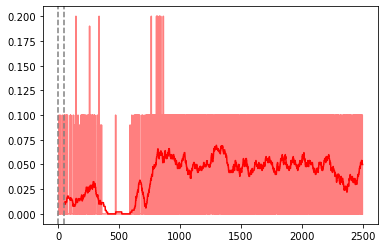

In [14]:
import matplotlib.pyplot as plt

smooth_period = 50
episode_markers = [0,50]
colour='r'

fig, ax = plt.subplots()
ax.plot(score_history,color=colour,alpha=0.5)
ave, inds = moving_average(score_history,smooth_period)
ax.plot(inds,ave,color=colour)
for m in episode_markers:
    ax.axvline(m,color='0.5',ls='--')
plt.show()